In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import glob
import json
import os
from pathlib import Path
import pickle
import re
import shutil

from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from keras.preprocessing.image import (ImageDataGenerator, array_to_img,
                                       img_to_array, load_img)
from keras.utils import plot_model
import pandas as pd
from scipy.spatial.distance import cdist, pdist
from skimage.transform import resize
from sklearn.neighbors import BallTree
import seaborn as sns
import somoclu
import spacy
import tensorflow as tf
from tqdm import tqdm_notebook as tqdmn, tqdm_pandas as tqdmpd

from AlexNet import AlexNet, preprocess_image_batch
import multimodal_som as mmsom


def show_imgs(imgs, ax=None):
    N, M, IN, IM, C = imgs.shape
    imgs = imgs.transpose(0, 2, 1, 3, 4).reshape(N*IN, M*IM, C)
    if ax is None:
        ax = plt.figure(figsize=(16, 8)).gca()
    ax.imshow(imgs)


img_dir = Path('/data/master_thesis/Flickr8k_Dataset/')
mmsom.tqdm = tqdmn
sns.set(style='ticks', context='poster')
pd.set_option('display.max_rows', 12)

Populating the interactive namespace from numpy and matplotlib


/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/mtambos/anaconda/envs/thesis/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
alexnet, cnn_model = mmsom.create_cnn_model()

In [4]:
tokens = pd.read_table('/data/master_thesis/Flickr8k.lemma.token.txt',
                       names=['fname', 'doc'], index_col='fname', )
tokens['fname'] = tokens.index.str.replace(r'#\d', '')
tokens

,doc,fname
fname,,
1305564994_00513f9a5b.jpg#0,A man in street racer armor be examine the tir...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#1,Two racer drive a white bike down a road .,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#2,Two motorist be ride along on their vehicle th...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#3,Two person be in a small race car drive by a g...,1305564994_00513f9a5b.jpg
1305564994_00513f9a5b.jpg#4,Two person in race uniform in a street car .,1305564994_00513f9a5b.jpg
1351764581_4d4fb1b40f.jpg#0,A firefighter extinguish a fire under the hood...,1351764581_4d4fb1b40f.jpg
...,...,...
985067019_705fe4a4cc.jpg#4,"A young boy slide down an inflatable , be look...",985067019_705fe4a4cc.jpg
989754491_7e53fb4586.jpg#0,A girl in a pool wear goggles and surround by ...,989754491_7e53fb4586.jpg


In [3]:
test_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_sentence/test_captions.csv')
test_captions = pd.read_csv(test_captions_fname)
print(len(test_captions))
print(len(test_captions.drop_duplicates(['caption', 'fname'])))
test_captions.head()

5000
4996


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,caption_id,caption,fname
0,0.037732,0.045537,-0.020955,0.006680,0.070910,-0.049869,0.029840,-0.030464,0.036346,0.548882,...,-0.013192,0.041304,0.012939,-0.037970,-0.026705,-0.006370,-0.003952,60,A football player pause during a game .,2003663004_5b70920a98.jpg
1,0.014724,0.063039,-0.057057,-0.016965,0.110055,-0.042216,0.030348,-0.049374,-0.016775,0.566889,...,-0.036040,-0.000102,-0.013865,-0.006182,-0.042786,0.023432,0.022641,61,A football player wear a green jersey with the...,2003663004_5b70920a98.jpg
2,0.014814,0.005030,-0.022480,-0.018195,0.058150,-0.043742,0.026591,-0.039487,-0.009939,0.582646,...,-0.062548,0.004945,0.013774,-0.008256,-0.051230,0.005148,0.023153,62,Greenbay football player be be hand a towel on...,2003663004_5b70920a98.jpg
3,0.001684,0.006027,-0.013932,-0.019524,0.104200,0.010280,-0.007210,-0.059592,0.038329,0.371364,...,-0.051028,-0.016344,0.007495,-0.009455,-0.047931,0.011650,0.022446,63,Green Bay Packer player cool off,2003663004_5b70920a98.jpg
4,0.008613,0.027409,-0.039114,0.001820,0.073818,-0.018728,0.009165,-0.055253,0.006646,0.560673,...,-0.062440,-0.015232,0.028333,-0.023838,-0.038883,0.011683,0.009937,64,Someone take a cloth off of a Green Bay Packer...,2003663004_5b70920a98.jpg


In [2]:
train_captions_fname = Path('/data/master_thesis/image_retrieval_flickr8k_sentence/train_captions.csv')
train_captions = pd.read_csv(train_captions_fname)
print(len(train_captions))
print(len(train_captions.drop_duplicates(['caption', 'fname'])))
train_captions.head()

35450
35416


,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_293,vector_294,vector_295,vector_296,vector_297,vector_298,vector_299,caption_id,caption,fname
0,0.059141,0.036055,-0.035976,-0.021229,0.034506,-0.024320,-0.010224,-0.010855,-0.047124,0.616510,...,-0.086013,-0.071571,-0.010292,0.035452,0.029460,0.019317,0.029077,0,A man in street racer armor be examine the tir...,1305564994_00513f9a5b.jpg
1,0.073441,0.030975,-0.052913,-0.031325,0.064727,-0.027603,-0.034505,-0.041931,-0.016869,0.533348,...,-0.068847,-0.052211,-0.013899,0.065105,0.008453,0.003317,0.001167,1,Two racer drive a white bike down a road .,1305564994_00513f9a5b.jpg
2,0.009272,0.022593,-0.051381,-0.048256,0.027223,0.007150,-0.008053,-0.037576,-0.044204,0.637286,...,-0.030701,-0.023398,-0.012386,0.031703,-0.010835,0.032592,0.023750,2,Two motorist be ride along on their vehicle th...,1305564994_00513f9a5b.jpg
3,0.018424,0.036897,-0.042137,-0.023089,0.056763,-0.031884,-0.014044,-0.056301,-0.012081,0.618858,...,-0.074767,-0.025118,0.019615,0.017526,-0.000883,0.009951,0.020180,3,Two person be in a small race car drive by a g...,1305564994_00513f9a5b.jpg
4,0.040224,0.030238,-0.028448,-0.015987,0.073690,-0.037041,-0.020101,-0.043726,-0.009675,0.653297,...,-0.071367,-0.033337,0.006312,0.004101,0.006483,0.008387,0.041728,4,Two person in race uniform in a street car .,1305564994_00513f9a5b.jpg


In [7]:
model = mmsom.MultimodalSOM()
model.load('som_planar_rectangular')

In [8]:
vec2img_train_fname = Path('vec2img_train.csv')
if vec2img_train_fname.exists():
    vec2img_train = pd.read_csv(vec2img_train_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_train = []
    for fname in tqdmn(set(train_captions.fname)):
        fname = img_dir / fname
        vec2img_train.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_train = pd.DataFrame(
        vec2img_train, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_train = vec2img_train.set_index('fname')
    vec2img_train.to_csv(vec2img_train_fname)
vec2img_train.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/3638783120_f600ceb19d.jpg,0.00000,2.467288,0.000000,0.000000,0.000000,0.000000,1.730055,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,3.426962
/data/master_thesis/Flickr8k_Dataset/532914728_c5d8d56b0b.jpg,0.00000,2.292454,0.000000,1.098026,3.237887,0.000000,1.905332,0.000000,0.000000,0.971649,...,0.230002,0.000000,0.000000,0.000000,0.000000,1.816965,0.692272,0.0,0.386787,0.000000
/data/master_thesis/Flickr8k_Dataset/2065875490_a46b58c12b.jpg,0.00000,0.678242,0.000000,0.354534,1.877741,0.642301,0.481772,0.425352,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.424661,0.000000,0.000000,1.323127,0.0,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/3503689049_63212220be.jpg,3.07929,0.000000,2.310428,0.000000,1.227665,0.000000,2.341258,0.596304,2.152261,0.000000,...,0.000000,2.667195,1.631657,0.000000,3.473524,0.000000,0.000000,0.0,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/3155501473_510f9c9f6b.jpg,0.00000,0.648416,0.000000,0.000000,0.000000,0.000000,2.124795,0.535745,0.000000,0.000000,...,0.000000,1.824369,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,2.698630,0.000000


In [9]:
vec2img_test_fname = Path('vec2img_test.csv')
if vec2img_test_fname.exists():
    vec2img_test = pd.read_csv(vec2img_test_fname, index_col='fname')
else:
    _, mmsom.get_image_features.cnn_model = mmsom.create_cnn_model()
    vec2img_test = []
    for fname in tqdmn(set(test_captions.fname)):
        fname = img_dir / fname
        vec2img_test.append((fname, *mmsom.get_image_features(fname)[0]))
    vec2img_test = pd.DataFrame(
        vec2img_test, columns=('fname', *[f'vector_{i}' for i in range(mmsom.IMG_OUT_SHAPE)])
    )
    vec2img_test = vec2img_test.set_index('fname')
    vec2img_test.to_csv(vec2img_test_fname)
vec2img_test.head()

,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,vector_8,vector_9,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
fname,,,,,,,,,,,,,,,,,,,,,
/data/master_thesis/Flickr8k_Dataset/3131107810_7e9b96cddc.jpg,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.451859,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.773229,0.0,1.604870,0.000000,0.000000,3.292542
/data/master_thesis/Flickr8k_Dataset/3353328134_dd9ed0edab.jpg,0.0,0.000000,0.0,0.00000,0.845025,0.0,1.475624,0.000000,0.0,0.000000,...,1.522981,0.000000,1.079615,2.468883,0.000000,0.0,0.000000,0.061936,0.254199,0.000000
/data/master_thesis/Flickr8k_Dataset/3630102841_b4c3e00b2c.jpg,0.0,0.000000,0.0,0.00000,1.412328,0.0,2.018209,3.007190,0.0,0.000000,...,0.000000,0.194701,0.000000,0.000000,0.000000,0.0,1.680213,0.000000,0.000000,0.000000
/data/master_thesis/Flickr8k_Dataset/141755290_4b954529f3.jpg,0.0,0.000000,0.0,0.00000,0.000000,0.0,3.834889,0.000000,0.0,0.000000,...,0.871925,1.090505,0.000000,0.000000,0.000000,0.0,1.535131,0.000000,0.000000,1.104217
/data/master_thesis/Flickr8k_Dataset/3563461991_de05537878.jpg,0.0,1.047649,0.0,1.58826,0.000000,0.0,0.057255,0.000000,0.0,0.643331,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,3.504717,0.000000,3.312575,0.000000


In [15]:
from sklearn.manifold import TSNE

projection = TSNE().fit_transform(model.som_model.codebook.reshape(10000, 4396))

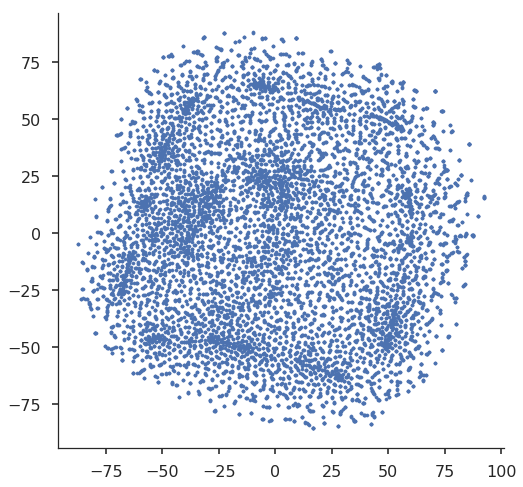

In [16]:
plt.figure(figsize=(8, 8))
plt.scatter(*projection.T, s=10)
sns.despine()

/home/mtambos/anaconda/envs/thesis/lib/python3.6/site-packages/scipy/spatial/distance.py:1832: RuntimeWarning: invalid value encountered in true_divide
  dm /= _row_norms(XA).reshape(-1, 1)


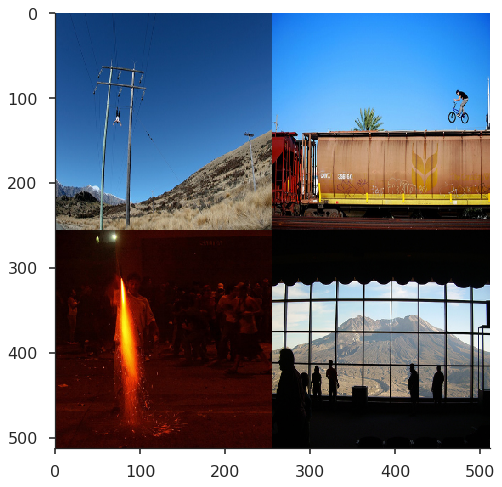

In [13]:
knn_ids = model.get_knn_images(word='dog water', k=4, vec2img=vec2img_test)
knn = vec2img_test.index[knn_ids]
imgs = np.zeros((len(knn), 256, 256, 3))
for i, fname in enumerate(knn):
    fname = Path(fname)
    img = plt.imread(fname)
    img = resize(img, (224, 224, 3), mode='constant')
    imgs[i] = resize(plt.imread(fname), (256, 256), mode='constant')

imgs = imgs.reshape(2, len(knn)//2, 256, 256, 3)
show_imgs(imgs)
sns.despine()



In [10]:
results_sentences = {}
for (fname, caption_id), group in tqdmn(test_captions.groupby(['fname', 'caption_id'])):
    caption = group.caption.iloc[0]
    knn_ids = model.get_knn_images(doc=caption, k=20, vec2img=vec2img_test)
    knn = vec2img_test.index[knn_ids]
    results_sentences[(fname, caption_id%5, caption)] = knn.copy()
results_sentences

HBox(children=(IntProgress(value=0, max=5000), HTML(value='')))

{('1007129816_e794419615.jpg',
  0,
  'A man in an orange hat star at something .'): Index(['/data/master_thesis/Flickr8k_Dataset/507758961_e63ca126cc.jpg',
        '/data/master_thesis/Flickr8k_Dataset/1561658940_a947f2446a.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2512682478_b67cc525c7.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2672445419_251ce9419a.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3675742996_02ccef16a3.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2173677067_9d0732bcc2.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2577972703_a22c5f2a87.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3520321387_710ab74cda.jpg',
        '/data/master_thesis/Flickr8k_Dataset/2531531628_b4a5041680.jpg',
        '/data/master_thesis/Flickr8k_Dataset/514222303_cb98584536.jpg',
        '/data/master_thesis/Flickr8k_Dataset/3618115051_41b5a7706c.jpg',
        '/data/master_thesis/Flickr8k_Dataset/1476241331_2f43b67aed.jpg',
        '/data/master_thesis/F

In [11]:
import pickle

with open('results_sentences.pickle', 'wb') as fp:
    pickle.dump(results_sentences, fp)

In [2]:
import pickle

with open('results_sentences.pickle', 'rb') as fp:
    results_sentences = pickle.load(fp)

In [17]:
np.mean([1 if fname in r[:1].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0114

In [18]:
np.mean([1 if fname in r[:2].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.018

In [19]:
np.mean([1 if fname in r[:5].map(lambda p: Path(p).name) else 0
         for (fname, caption_id, caption), r in results_sentences.items()])

0.0396

In [20]:
fh10 = np.mean([1 if fname in r[:10].map(lambda p: Path(p).name) else 0
                for (fname, caption_id, caption), r in results_sentences.items()])
f'{fh10:0.4f}'

'0.0680'

In [21]:
fh20 = np.mean([1 if fname in r[:20].map(lambda p: Path(p).name) else 0
                for (fname, caption_id, caption), r in results_sentences.items()])
f'{fh20:0.4f}'

'0.1072'